In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
!wget https://raw.githubusercontent.com/sharooqfarzeen/Bigram-Language-Model/main/names.txt

--2024-07-08 07:53:46--  https://raw.githubusercontent.com/sharooqfarzeen/Bigram-Language-Model/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-07-08 07:53:46 (9.48 MB/s) - ‘names.txt’ saved [228145/228145]



In [5]:
#reading names as a list of strings into words
with open('names.txt', 'r') as f:
  words = f.read().splitlines()

In [6]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
len(words)

32033

## Mapping characters to integers

#### Creating character set

In [8]:
#set of characters
char_set = set(''.join(words))
#list of characters
char_list = []
char_list.append("<S>") #adding start character to list
char_list.extend(sorted(list(char_set)))
char_list.append(".") #adding end character
char_list

['<S>',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '.']

#### Mapping to integers

In [9]:
stoi = {s:i for i,s in enumerate(char_list)}
stoi['a'], stoi['z']

(1, 26)

#### Reverse mapping

In [10]:
itos = {i:s for s,i in stoi.items()}
itos[1], itos[27]

('a', '.')

## Building the dataset of Trigrams

In [11]:
block_size = 3 #trigram

def build_dataset(words):
  X = [] #context
  Y = [] #result/next character

  for word in words:
    context = [0] * block_size
    # print(word)
    for ch in word + ".":
      ix = stoi[ch]
      X.append(context) #context trigram
      Y.append(ix)  #result character of trigram
      context_string = ''.join([itos[i] for i in context])
      # print(f'{context_string} ---> {ch}')
      context = context[1:] + [ix] #context window moves one character ahead

  X = torch.tensor(X, device=device)
  Y = torch.tensor(Y, device=device)

  print(X.shape, Y.shape)

  return X, Y

```
emma
<S><S><S> ---> e
<S><S>e ---> m
<S>em ---> m
emm ---> a
mma ---> .
```



### Creating training, validation and testing datasets

In [13]:
#shuffle word list
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


### Initializing weights and biases

In [16]:
g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility
C = torch.randn((28, 10), generator=g, device=device)
W1 = torch.randn((30, 200), generator=g, device=device)
b1 = torch.randn(200, generator=g, device=device)
W2 = torch.randn((200, 28), generator=g, device=device)
b2 = torch.randn(28, generator=g, device=device)
parameters = [C, W1, b1, W2, b2]

In [17]:
sum(p.nelement() for p in parameters) # number of parameters in total

12108

In [18]:
for p in parameters:
  p.requires_grad = True

#### Creating a list of learning rates from 0.001 to 1

In [21]:
lre = torch.linspace(-3, 0, 1000, device=device)
lrs = 10**lre

In [22]:
lri = [] #learning rate for step i
lossi = [] #loss for step i
stepi = [] #step number

## Network Training

In [23]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,), device=device)

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 28)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #learning rate starts at 0.1 and is later decrement to 0.01 is later steps
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

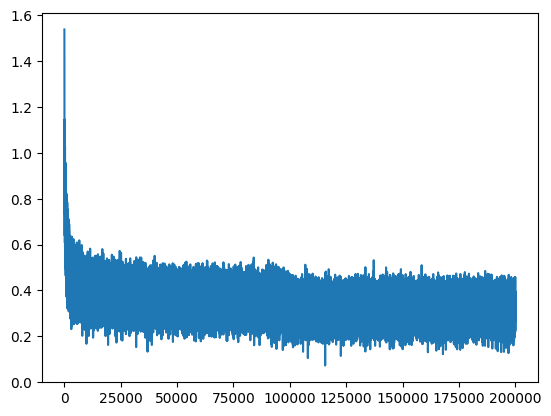

In [25]:
plt.plot(stepi, lossi)

## Training Loss

In [26]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1142, device='cuda:0', grad_fn=<NllLossBackward0>)

## Validation Loss

In [27]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1634, device='cuda:0', grad_fn=<NllLossBackward0>)

## Visualizing dimensions 0 and 1 of the embedding matrix C for all characters


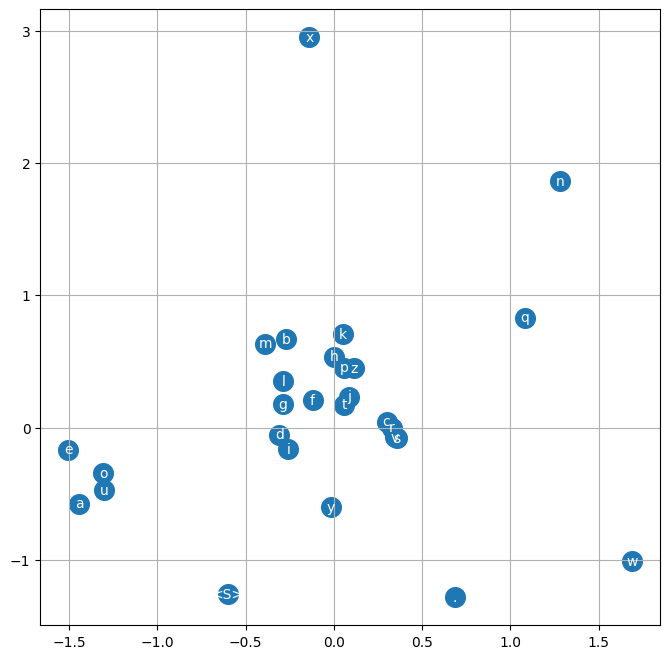

In [29]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].cpu().data, C[:,1].cpu().data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# Generating new names from the model

In [36]:
g = torch.Generator(device=device).manual_seed(2147483647 + 10)

generated_names = []

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 27:
        break

    generated_names.append((''.join(itos[i] for i in out)))

In [37]:
print(*generated_names, sep="\n")

bik.
trys.
zemadel.
alaj.
sharda.
ley.
jeidy.
omurah.
emin.
jagg.
adge.
wylliss.
mel.
tarello.
kaila.
tegett.
noheidyn.
zazhran.
damilanai.
sigh.


In [39]:
with open("Generated Names.txt", 'w') as f:
  for name in generated_names:
    f.write(f'{name}\n')